# Streamflow Forecasting with ANN and LSTM

**Project Goal:** This project aims to replicate the methodology of the reference study "Application of Artificial Neural Network in Streamflow Forecasting". We will use the CAMELS dataset to build and evaluate two neural network models for predicting daily streamflow based on historical rainfall and runoff data.

### Procedure Overview
1.  **Data Acquisition:** Download and process the CAMELS dataset.
2.  **Data Preprocessing:** Clean, split, and normalize the data.
3.  **Feature Engineering:** Create lagged input sequences for the models.
4.  **Model Implementation:** Build and train a Standard Feed-Forward NN and an LSTM.
5.  **Evaluation:** Compare model performance using RMSE, with a focus on peak vs. non-peak flows.

In [1]:
# Import necessary libraries
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

print("--- Phase 2: Data Preprocessing for Modeling ---")

# --- Step 2.1: Load and Select Data ---
print("\nStep 2.1: Loading and cleaning data...")
# Define the path to our processed data file
nc_file_path = 'data/processed/CAMELS.nc'

# Load the NetCDF dataset
dataset = xr.open_dataset(nc_file_path)

# Select the precipitation (daymet_prcp) and streamflow (QObs) for the first basin
# The .isel(station_ids=0) selects the first (and only) basin in our file
# Then, convert it to a pandas DataFrame for easy manipulation
basin_data = dataset[['daymet_prcp', 'QObs']].isel(station_ids=0).to_dataframe()

# Rename columns to be more intuitive, matching our report's terminology
basin_data = basin_data.rename(columns={'daymet_prcp': 'precipitation', 'QObs': 'runoff'})

# Drop any rows with missing values to ensure the dataset is clean
basin_data = basin_data.dropna()

# Select only the two columns we need for our model
basin_data = basin_data[['precipitation', 'runoff']]

print("Data for one basin has been successfully loaded and cleaned.")
print("Data shape:", basin_data.shape)
print("First 5 rows of data:")
print(basin_data.head())


# --- Step 2.2: Chronological Train-Test Split ---
print("\nStep 2.2: Splitting data into training and testing sets...")
# Calculate the split point for an 80% training set
split_index = int(len(basin_data) * 0.8)

# Split the DataFrame. It's crucial not to shuffle time-series data.
train_df = basin_data.iloc[:split_index]
test_df = basin_data.iloc[split_index:]

print(f"Training set contains {len(train_df)} days.")
print(f"Testing set contains {len(test_df)} days.")


# --- Step 2.3: Normalize the Data ---
print("\nStep 2.3: Normalizing the data...")
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler ONLY on the training data to avoid data leakage
scaler.fit(train_df)

# Transform both the training and testing data into a range of [0, 1]
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

# Save the fitted scaler to a file. This is critical for later.
# First, ensure the 'models' directory exists
os.makedirs('models', exist_ok=True)
joblib.dump(scaler, 'models/scaler.pkl')

print("Data has been successfully normalized.")
print("The scaler object has been saved to 'models/scaler.pkl'.")
print("\n--- Preprocessing Complete ---")

--- Phase 2: Data Preprocessing for Modeling ---

Step 2.1: Loading and cleaning data...
Data for one basin has been successfully loaded and cleaned.
Data shape: (3653, 2)
First 5 rows of data:
            precipitation  runoff
time                             
2000-01-01           0.00  1080.0
2000-01-02           3.98  1010.0
2000-01-03           7.49   990.0
2000-01-04           4.11   968.0
2000-01-05           3.41   957.0

Step 2.2: Splitting data into training and testing sets...
Training set contains 2922 days.
Testing set contains 731 days.

Step 2.3: Normalizing the data...
Data has been successfully normalized.
The scaler object has been saved to 'models/scaler.pkl'.

--- Preprocessing Complete ---


---
## Phase 3: Feature Engineering for Time Series Forecasting

**Goal:** To transform our time series data into a supervised learning format. The model needs to be given an explicit input (`X`) and a corresponding output (`y`). The reference study's method is based on using a sequence of past rainfall and runoff values to predict the current day's runoff. We will now create these input sequences.

In [2]:
import numpy as np

print("--- Phase 3: Feature Engineering ---")

# --- Step 3.1: Create a Feature Engineering Function ---
def create_sequences(data, sequence_length):
    """
    Transforms a time series dataset into input sequences (X) and target values (y).

    Args:
        data (np.array): The scaled time series data (e.g., train_scaled).
        sequence_length (int): The number of previous time steps to use as input features.

    Returns:
        tuple: A tuple containing:
               - X (np.array): The input features (sequences).
               - y (np.array): The target values (the runoff on the day after the sequence).
    """
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        # The input sequence is a window from the current position 'i' to 'i + sequence_length'
        X.append(data[i:i + sequence_length])
        
        # The target is the 'runoff' value on the day immediately following the input sequence.
        # In our scaled data, runoff is the second column (index 1).
        y.append(data[i + sequence_length, 1])
        
    return np.array(X), np.array(y)

print("\nStep 3.1 Complete: Sequence creation function defined.")


# --- Step 3.2: Generate Training and Testing Sequences ---
# Define the sequence length (number of lag days). The reference study tested various lags.
# A common starting point is 30 days of history to predict the next day.
# This value is a hyperparameter we can tune later.
SEQUENCE_LENGTH = 30 

# Use the function to create the final datasets
X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQUENCE_LENGTH)

print(f"\nStep 3.2 Complete: Training and testing sequences generated with a lag of {SEQUENCE_LENGTH} days.")
print("\nShape of the final datasets:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")
print("\n--- Feature Engineering Complete ---")

--- Phase 3: Feature Engineering ---

Step 3.1 Complete: Sequence creation function defined.

Step 3.2 Complete: Training and testing sequences generated with a lag of 30 days.

Shape of the final datasets:
X_train shape: (2892, 30, 2)
y_train shape: (2892,)
X_test shape:  (701, 30, 2)
y_test shape:  (701,)

--- Feature Engineering Complete ---


### Step 3.3 : Save Final Model-Ready Data to Files

To inspect the final data and create a permanent record, we will save the `X_train`, `y_train`, `X_test`, and `y_test` arrays to CSV files. Since the input data (`X`) is 3-dimensional, we will first reshape it into a 2-dimensional table format suitable for a CSV file.

In [ ]:
import pandas as pd
import os

print("--- Step 3.3: Saving Final Data to Files ---")

num_samples_train, timesteps, features = X_train.shape
num_samples_test = X_test.shape[0]

X_train_reshaped = X_train.reshape(num_samples_train, timesteps * features)
X_test_reshaped = X_test.reshape(num_samples_test, timesteps * features)

columns = []
for i in range(timesteps, 0, -1):
    columns.append(f'precipitation_lag_{i}')
    columns.append(f'runoff_lag_{i}')

X_train_df = pd.DataFrame(X_train_reshaped, columns=columns)
y_train_df = pd.DataFrame(y_train, columns=['target_runoff'])

X_test_df = pd.DataFrame(X_test_reshaped, columns=columns)
y_test_df = pd.DataFrame(y_test, columns=['target_runoff'])

# --- Define output paths and save to CSV ---
output_dir = 'data/processed'
X_train_df.to_csv(os.path.join(output_dir, 'X_train_features.csv'), index=False)
y_train_df.to_csv(os.path.join(output_dir, 'y_train_target.csv'), index=False)
X_test_df.to_csv(os.path.join(output_dir, 'X_test_features.csv'), index=False)
y_test_df.to_csv(os.path.join(output_dir, 'y_test_target.csv'), index=False)


print(f"\nSuccessfully saved 4 new files to the '{output_dir}' directory:")
print(f"- X_train_features.csv (Shape: {X_train_df.shape})")
print(f"- y_train_target.csv (Shape: {y_train_df.shape})")
print(f"- X_test_features.csv (Shape: {X_test_df.shape})")
print(f"- y_test_target.csv (Shape: {y_test_df.shape})")

--- Step 3.3: Saving Final Data to Files ---

Successfully saved 4 new files to the 'data/processed' directory:
- X_train_features.csv (Shape: (2892, 60))
- y_train_target.csv (Shape: (2892, 1))
- X_test_features.csv (Shape: (701, 60))
- y_test_target.csv (Shape: (701, 1))


---
## Phase 4: Model Implementation and Training

In this phase, we will build, compile, and train the two neural network architectures as described in the reference study.

### 4.1 Model A: Long Short-Term Memory (LSTM) Network

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("--- Phase 4.1: Building the LSTM Model ---")

# Define Model Architecture using hyperparameters from the reference study's best LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
HIDDEN_SIZE = 12
LEARNING_RATE = 0.001

model_lstm = Sequential([
    LSTM(units=HIDDEN_SIZE, input_shape=input_shape),
    Dense(1) # Output layer for regression
])

# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

print("\nLSTM Model Architecture:")
model_lstm.summary()

--- Phase 4.1: Building the LSTM Model ---

LSTM Model Architecture:


c:\Users\chait\OneDrive\Documents\gathub\ANN-Streamflow-Forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 733 (2.86 KB)

 Trainable params: 733 (2.86 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
print("\n--- Training the LSTM Model ---")
# The reference study used 200 epochs. We'll use a smaller number for this first run.
EPOCHS = 200
BATCH_SIZE = 64

history_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1 # This will show a progress bar
)

print("\n--- LSTM Model Training Complete ---")


--- Training the LSTM Model ---
Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0094 - val_loss: 0.0099
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.9359e-04 - val_loss: 0.0016
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9551e-04 - val_loss: 0.0014
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1744e-04 - val_loss: 0.0013
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5273e-04 - val_loss: 0.0013
Epoch

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

print("--- Phase 5: Evaluating the LSTM Model ---")

# --- Step 5.1: Make Predictions on the Test Set ---
# Use the trained model to predict the runoff for the entire test dataset.
predictions_scaled = model_lstm.predict(X_test)

# --- Step 5.2: Inverse-Transform the Data to Real-World Units ---
# It's crucial to convert our scaled predictions back to the original units (cubic feet per second)
# so we can understand the real-world error.

# Load the scaler object we saved during preprocessing
scaler = joblib.load('models/scaler.pkl')

# The scaler was trained on a 2-column array ([precipitation, runoff]).
# Our model's output is just the runoff, so we need to create a dummy array
# of the correct shape to use the scaler's inverse_transform function.

# Create a dummy array with zeros, shaped like our original data (n_samples, 2 features)
dummy_array_preds = np.zeros((len(predictions_scaled), 2))
# Place our scaled predictions into the second column (the 'runoff' column)
dummy_array_preds[:, 1] = predictions_scaled.flatten()
# Now, inverse-transform the whole array
predictions_real = scaler.inverse_transform(dummy_array_preds)[:, 1]

# We must also inverse-transform the true test values to compare apples to apples.
dummy_array_true = np.zeros((len(y_test), 2))
dummy_array_true[:, 1] = y_test.flatten()
y_test_real = scaler.inverse_transform(dummy_array_true)[:, 1]


# --- Step 5.3: Calculate Root Mean Squared Error (RMSE) ---
# RMSE is the standard metric for regression problems and was used in the reference study.
# It gives us the average error of our model in the original units.
rmse = np.sqrt(mean_squared_error(y_test_real, predictions_real))

print(f"\nEvaluation Complete.")
print(f"The Overall Root Mean Squared Error (RMSE) on the test set is: {rmse:.2f} cubic feet per second.")

--- Phase 5: Evaluating the LSTM Model ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Evaluation Complete.
The Overall Root Mean Squared Error (RMSE) on the test set is: 263.53 cubic feet per second.


--- Visualizing Model Training History ---


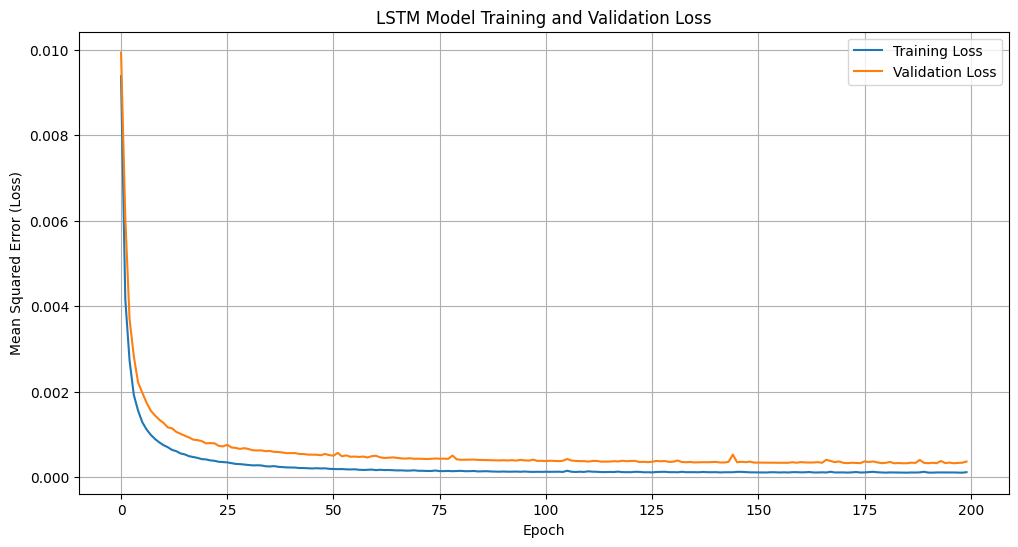

In [7]:
import matplotlib.pyplot as plt

print("--- Visualizing Model Training History ---")

# Create a new figure for the plot
plt.figure(figsize=(12, 6))

# Plot the training loss (the model's score on the data it studied)
plt.plot(history_lstm.history['loss'], label='Training Loss')

# Plot the validation loss (the model's score on the unseen practice exam)
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')

# Add titles and labels for clarity
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

--- Visualizing Predictions vs. Actual Values ---


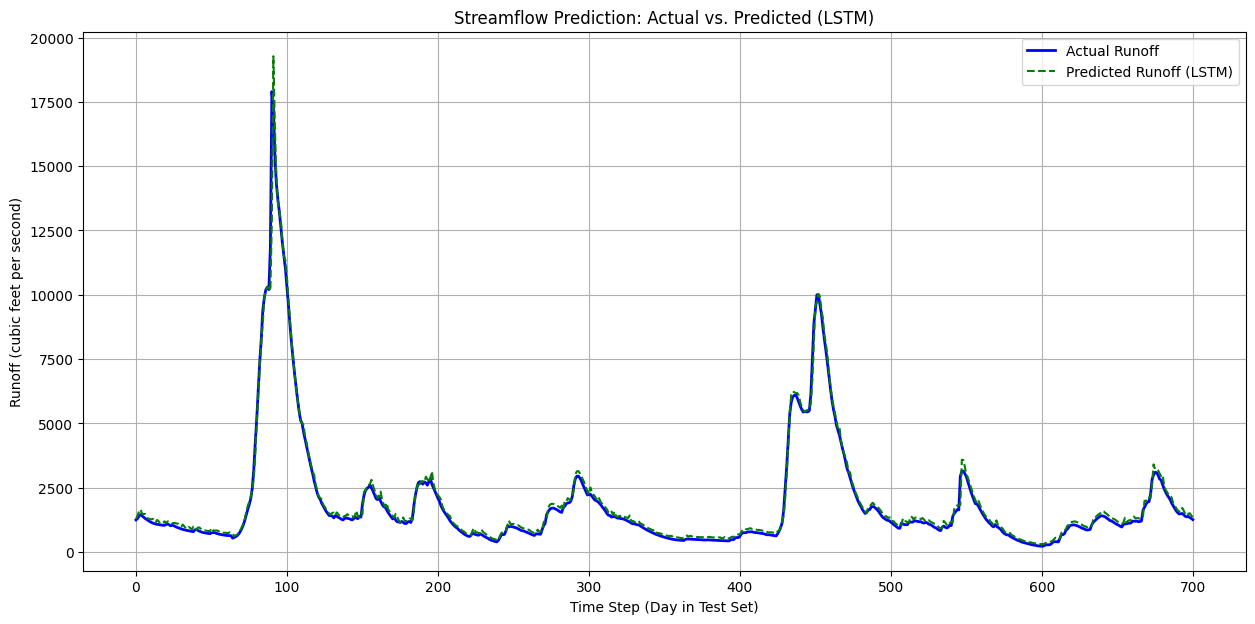

In [8]:
import matplotlib.pyplot as plt

print("--- Visualizing Predictions vs. Actual Values ---")

# Create a new figure for the plot
plt.figure(figsize=(15, 7))

# Plot the actual, real-world runoff values from the test set
plt.plot(y_test_real, label='Actual Runoff', color='blue', linewidth=2)

# Plot the model's predictions (also in real-world units)
plt.plot(predictions_real, label='Predicted Runoff (LSTM)', color='green', linestyle='--')

# Add titles and labels
plt.title('Streamflow Prediction: Actual vs. Predicted (LSTM)')
plt.xlabel('Time Step (Day in Test Set)')
plt.ylabel('Runoff (cubic feet per second)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

print("--- Final Analysis: Peak vs. Non-Peak Flow Performance ---")

# --- Step 1: Define the Peak Flow Threshold ---
# We need to decide what constitutes a "peak". A common method is to use a percentile of the
# actual runoff data. Let's use the 90th percentile: any day with runoff in the top 10% is a "peak day".
peak_threshold = np.percentile(y_test_real, 90)

print(f"The threshold for a 'peak flow' day is set at the 90th percentile: {peak_threshold:.2f} cfs.")

# --- Step 2: Separate the Data into Peak and Non-Peak Sets ---
# Create a boolean "mask" to identify which days are peak days.
is_peak = y_test_real >= peak_threshold

# Use the mask to select the true values and predictions for peak days
peak_true = y_test_real[is_peak]
peak_predictions = predictions_real[is_peak]

# Use the inverse of the mask (~is_peak) to select the non-peak days
non_peak_true = y_test_real[~is_peak]
non_peak_predictions = predictions_real[~is_peak]

print(f"There are {len(peak_true)} 'peak' days and {len(non_peak_true)} 'non-peak' days in the test set.")

# --- Step 3: Calculate RMSE for Each Subset ---
rmse_peak = np.sqrt(mean_squared_error(peak_true, peak_predictions))
rmse_non_peak = np.sqrt(mean_squared_error(non_peak_true, non_peak_predictions))


# --- Step 4: Display the Final Results ---
print("\n--- LSTM Model Performance Summary ---")
print(f"Overall RMSE:    {rmse:.2f} cfs")
print(f"Non-Peak RMSE:   {rmse_non_peak:.2f} cfs (Error on the 90% of days with lower flow)")
print(f"Peak RMSE:       {rmse_peak:.2f} cfs (Error on the 10% of days with highest flow)")

--- Final Analysis: Peak vs. Non-Peak Flow Performance ---
The threshold for a 'peak flow' day is set at the 90th percentile: 4110.00 cfs.
There are 71 'peak' days and 630 'non-peak' days in the test set.

--- LSTM Model Performance Summary ---
Overall RMSE:    263.53 cfs
Non-Peak RMSE:   139.74 cfs (Error on the 90% of days with lower flow)
Peak RMSE:       715.82 cfs (Error on the 10% of days with highest flow)


---
### 4.2 Model B: Standard Feed-Forward Neural Network (ANN)

This model, described as the "Standard network" in the reference study, uses a simple, fully connected architecture. Unlike the LSTM, it requires the 3D sequence data to be "flattened" into a 2D format before training.

In [ ]:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense

    print("--- Phase 4.2: Preparing Data and Building the Standard NN Model ---")


    num_samples, timesteps, features = X_train.shape
    X_train_ann = X_train.reshape(num_samples, timesteps * features)
    X_test_ann = X_test.reshape(X_test.shape[0], timesteps * features)

    print(f"Reshaped X_train from {X_train.shape} to {X_train_ann.shape}")

 
    HIDDEN_SIZE_ANN = 12
    LEARNING_RATE_ANN = 0.009

    model_ann = Sequential([
       
        Dense(HIDDEN_SIZE_ANN, activation='sigmoid', input_shape=(X_train_ann.shape[1],)),
        
       
        Dense(1)
    ])

    optimizer_ann = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ANN)
    model_ann.compile(optimizer=optimizer_ann, loss='mean_squared_error')

    print("\nStandard NN Model Architecture:")
    model_ann.summary()

--- Phase 4.2: Preparing Data and Building the Standard NN Model ---
Reshaped X_train from (2892, 30, 2) to (2892, 60)

Standard NN Model Architecture:


c:\Users\chait\OneDrive\Documents\gathub\ANN-Streamflow-Forecasting\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 12)             │           732 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 745 (2.91 KB)

 Trainable params: 745 (2.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Training the Standard NN Model ---")
EPOCHS = 200
BATCH_SIZE = 64

history_ann = model_ann.fit(
    X_train_ann,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_ann, y_test),
    verbose=1 
)

print("\n--- Standard NN Model Training Complete ---")


--- Training the Standard NN Model ---
Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162 - val_loss: 0.0037
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3402e-04 - val_loss: 0.0012
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7035e-04 - val_loss: 0.0011
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9807e-04 - val_loss: 9.6508e-04
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2054e-04 - val_loss: 9.5186e-04
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8362e-04 - val_loss: 8.2573e-04
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5235e-04 - val_loss: 7.6773e-04
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2159e-04 - val_loss: 7.2797e-04
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

print("--- Phase 5: Evaluating the Standard NN Model ---")

predictions_scaled_ann = model_ann.predict(X_test_ann)

scaler = joblib.load('models/scaler.pkl')
dummy_preds = np.zeros((len(predictions_scaled_ann), 2))
dummy_preds[:, 1] = predictions_scaled_ann.flatten()
predictions_real_ann = scaler.inverse_transform(dummy_preds)[:, 1]

rmse_ann = np.sqrt(mean_squared_error(y_test_real, predictions_real_ann))

print(f"\nEvaluation Complete.")
print(f"The Overall Root Mean Squared Error (RMSE) for the ANN is: {rmse_ann:.2f} cubic feet per second.")

--- Phase 5: Evaluating the Standard NN Model ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Evaluation Complete.
The Overall Root Mean Squared Error (RMSE) for the ANN is: 280.87 cubic feet per second.


--- Visualizing ANN Training History ---


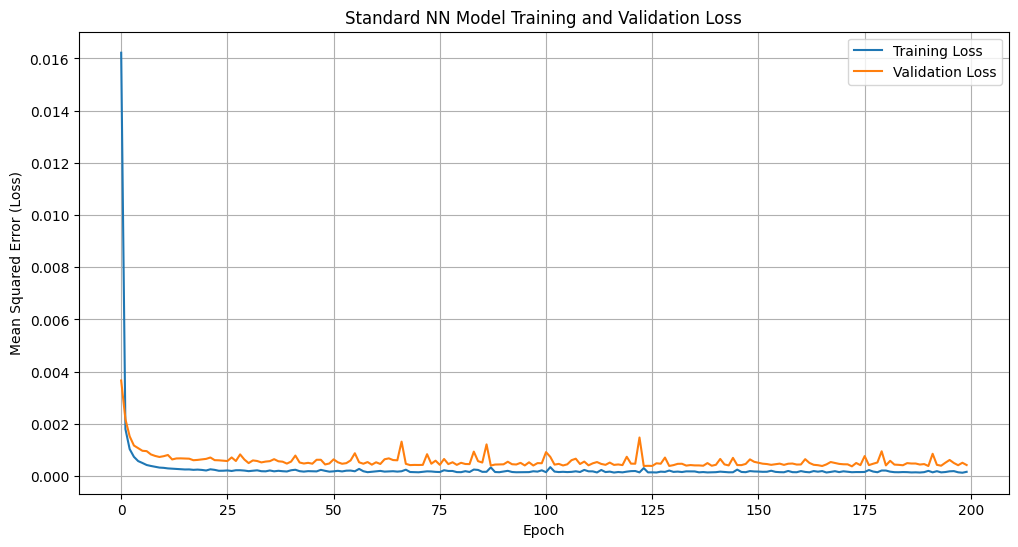

In [13]:
import matplotlib.pyplot as plt

print("--- Visualizing ANN Training History ---")
plt.figure(figsize=(12, 6))
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('Standard NN Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)


plt.show()

--- Visualizing ANN Predictions vs. Actual Values ---


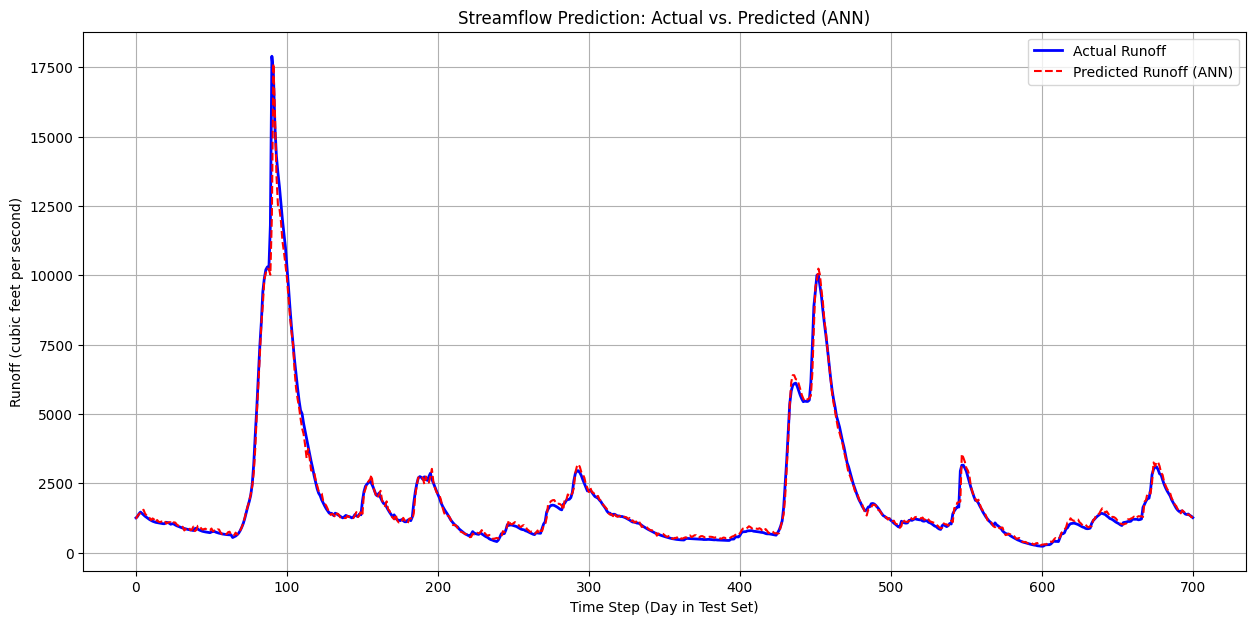

In [14]:
import matplotlib.pyplot as plt

print("--- Visualizing ANN Predictions vs. Actual Values ---")
plt.figure(figsize=(15, 7))
plt.plot(y_test_real, label='Actual Runoff', color='blue', linewidth=2)
plt.plot(predictions_real_ann, label='Predicted Runoff (ANN)', color='red', linestyle='--')
plt.title('Streamflow Prediction: Actual vs. Predicted (ANN)')
plt.xlabel('Time Step (Day in Test Set)')
plt.ylabel('Runoff (cubic feet per second)')
plt.legend()
plt.grid(True)

plt.show()

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

print("--- Final Analysis: ANN Peak vs. Non-Peak Flow Performance ---")

# We use the same threshold and mask as the LSTM analysis for a fair comparison.
peak_threshold = np.percentile(y_test_real, 90)
is_peak = y_test_real >= peak_threshold

# Select the predictions for peak and non-peak days
peak_predictions_ann = predictions_real_ann[is_peak]
non_peak_predictions_ann = predictions_real_ann[~is_peak]

# Calculate RMSE for each subset
rmse_peak_ann = np.sqrt(mean_squared_error(peak_true, peak_predictions_ann))
rmse_non_peak_ann = np.sqrt(mean_squared_error(non_peak_true, non_peak_predictions_ann))

print("\n--- Standard NN Model Performance Summary ---")
print(f"Overall RMSE:    {rmse_ann:.2f} cfs")
print(f"Non-Peak RMSE:   {rmse_non_peak_ann:.2f} cfs")
print(f"Peak RMSE:       {rmse_peak_ann:.2f} cfs")

--- Final Analysis: ANN Peak vs. Non-Peak Flow Performance ---

--- Standard NN Model Performance Summary ---
Overall RMSE:    280.87 cfs
Non-Peak RMSE:   112.01 cfs
Peak RMSE:       817.04 cfs


---
## Phase 6: Final Comparison and Conclusion

### 6.1: Final Performance Summary

In [16]:
import pandas as pd

# --- Create a summary table of the RMSE results ---

# Create a dictionary with the results from both models
results_data = {
    'Metric': ['Overall RMSE', 'Non-Peak RMSE', 'Peak RMSE'],
    'LSTM Model (cfs)': [rmse, rmse_non_peak, rmse_peak],
    'Standard NN Model (cfs)': [rmse_ann, rmse_non_peak_ann, rmse_peak_ann]
}

# Create a pandas DataFrame from the dictionary
results_df = pd.DataFrame(results_data)

# Set the 'Metric' column as the index for a cleaner display
results_df = results_df.set_index('Metric')

# Display the final results table, formatted to two decimal places
print("--- Final Model Performance Comparison ---")
display(results_df.style.format("{:.2f}"))

--- Final Model Performance Comparison ---


,LSTM Model (cfs),Standard NN Model (cfs)
Metric,,
Overall RMSE,263.53,280.87
Non-Peak RMSE,139.74,112.01
Peak RMSE,715.82,817.04


### 6.2: Combined Visualization of Predictions

--- Visualizing Both Models' Predictions vs. Actual Values ---


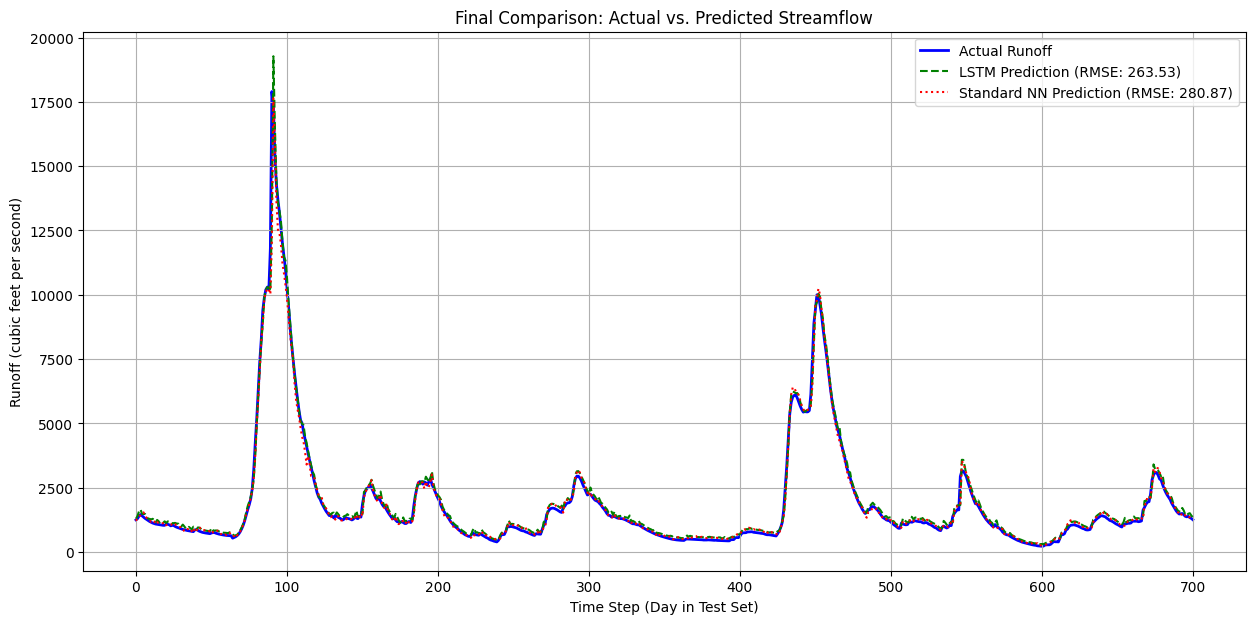

In [17]:
import matplotlib.pyplot as plt

print("--- Visualizing Both Models' Predictions vs. Actual Values ---")

# Create a new figure for the plot
plt.figure(figsize=(15, 7))

# Plot the actual, real-world runoff values (make it the most prominent)
plt.plot(y_test_real, label='Actual Runoff', color='blue', linewidth=2, zorder=1)

# Plot the LSTM model's predictions
plt.plot(predictions_real, label=f'LSTM Prediction (RMSE: {rmse:.2f})', color='green', linestyle='--', zorder=2)

# Plot the Standard NN model's predictions
plt.plot(predictions_real_ann, label=f'Standard NN Prediction (RMSE: {rmse_ann:.2f})', color='red', linestyle=':', zorder=2)

# Add titles and labels for clarity
plt.title('Final Comparison: Actual vs. Predicted Streamflow')
plt.xlabel('Time Step (Day in Test Set)')
plt.ylabel('Runoff (cubic feet per second)')
plt.legend()
plt.grid(True)

plt.show()

### 6.3: Save Final Trained Models

In [18]:
print("--- Saving final trained models to disk ---")

# Define the file paths for saving
lstm_model_path = 'models/lstm_model.h5'
ann_model_path = 'models/ann_model.h5'

# Save both trained models
model_lstm.save(lstm_model_path)
model_ann.save(ann_model_path)

print(f"LSTM model saved to: {lstm_model_path}")
print(f"Standard NN model saved to: {ann_model_path}")

--- Saving final trained models to disk ---
LSTM model saved to: models/lstm_model.h5
Standard NN model saved to: models/ann_model.h5
